로지스틱 회귀는 구현하기 쉽고 선형적으로 구분되는 클래스에 뛰어난 성능을 내는 분류 모델이다.
- 이진 분류를 위한 선형 모델이지만, 다중 분류로 확장할 수 있다.
- 예를들어, OvR 방식을 사용한다. 

오즈비: P / (1 - P)

로짓 함수: logit(P) = log( P / (1 - P) ) 

- 로직 함수는 0과 1 사이의 입력 값을 받아 실수 범위 값으로 변환한다.

특성의 가중치 합과 로짓 함수 사이의 선형 관계는 다음과 같이 쓸 수 있다.
$$logit(P(y = 1 | x)) = w_0x_0 + w_1x_1 + ... + w_mx_m = \sum_{i=0}^m w_ix_i = w^Tx$$   
여기서 $P(y = 1 | x)$는 특성 x가 주어졌을때 이 샘플이 클래스 1에 속할 조건부 확률이다.

어떤 샘플이 특정 클래스에 속할 확률을 예측하는 것이 관심 대상이므로 logit 함수를 거꾸로 뒤짚는다.
이 함수를 로지스틱 시그모이드 함수(logistic sigmoid function) 또는 시그모이드 함수(sigmoid function)라고도 한다.

$$\phi(z) = {1 \over 1 + e^{-z}} $$

여기서 z는 $w^Tx = w_0x_0 + w_1x_1 + ... + w_mx_m$ 이다. 이를 반영하면 시그모이드 함수는 다음과 같다.

$$\phi(w^Tx) = {1 \over 1 + e^{-w^Tx}} $$

시그모이드 함수가 어떤 모습인지 -7에서 7까지 그려보면 다음과 같다.

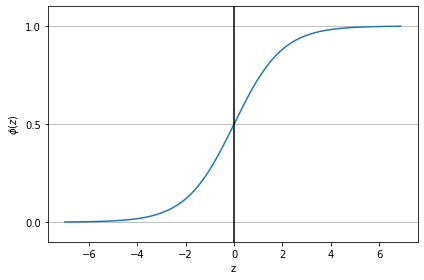

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k') # x가 0.0인 지점에 세로 축을 그린다.
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')

plt.yticks([0.0, 0.5, 1.0]) # y축의 눈금과 격자선을 설정한다.

# y축에 보조선을 그린다.
ax = plt.gca()
ax.yaxis.grid(True)

plt.tight_layout()
plt.show()

z가 무한대($\infty$)로 가면 $e^{-z}$가 매우 작아지기 때문에 $\phi(z)$는 1에 가까워진다.<br />
z가 $-\infty$로 가면 점점 분모가 커지기 때문에 $\phi(z)$는 0에 수렴한다.<br />
시그모이드 함수는 실수 입력 값을 [0, 1] 사이의 값으로 변환한다. 
중간은 $\phi(0) = 0.5$이다.

### 로지스틱 비용 함수의 가중치 학습

로지스틱 회귀의 비용 함수는 다음과 같다.

$$J(w) = \sum_{i=1}^n\biggl[ -y^{(i)}\log(\phi(z^{(i)}))-(1-y^{(i)})\log(1-\phi(z^{(i)})) \biggr]$$

따라서 샘플이 한개일때 비용을 계산하는 함수는 다음과 같다. 

$$J(\phi(z),y;w) = -y\log(\phi(z))-(1-y)\log(1-\phi(z))$$

식을 보면 y가 0일때는 첫번째 항이 0이되고, y가 1일때는 두번째 항이 0이 된다. 따라서 다음과 같이 나타낼 수 있다.

$J(\phi(z),y;w) =$
\begin{cases}
-\log(\phi(z)), & \text{if y is 1} \\
-\log(1-\phi(z)), & \text{if y is 0}
\end{cases}

샘플이 하나인 경우 $\phi(z)$ 값에 대한 분류 비용을 그리면 다음과 같다.

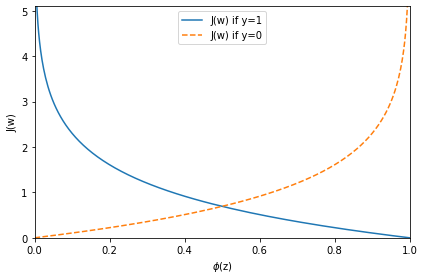

In [2]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)  # y축은 로지스틱 비용
plt.xlim([0, 1])    # x축은 0~1 범위의 시그모이드 활성화 값
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

클래스 1에 속한 샘플을 정확히 예측하면 비용이 0에 가까워진다.
클래스 0에 속한 샘플을 y=0으로 정확히 예측하면 y축의 비용이 0에 가까워진다.
둘다 예측이 잘못되면 무한대가 된다.

### 아달린 구현을 로지스틱 회귀 알고리즘으로 변경

로지스틱 회귀를 구현하려면 아달린 모델에 다음 세가지만 변경하면 된다. 
1. 비용 함수를 로지스틱 회귀 비용 함수로 변경
2. 선형 활성화 함수를 시그모이드로 변경
3. 임계 함수가 클래스 레이블 -1과 1이 아니고 0과 1을 반환하도록 변경

In [3]:
class LogisticRegressionGD(object):
    
    def __init__(self, eta=0.05, n_iter=100, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state= random_state
    
    def fit(self, x, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=1 + x.shape[1])
        self.cost_ = []
        
        for i in range(self.n_iter):
            net_input = self.net_input(x)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.eta * x.T.dot(errors)
            self.w_[0] += self.eta * errors.sum()
            
            cost = (-y.dot(np.log(output)) - ((1 - y).dot(np.log(1 - output))))
            self.cost_.append(cost)
        return self

    def net_input(self, x):     # 최종 입력 계산
        # np.dot() 함수는 입력받은 두 값 또는 array 또는 행렬을 곱한다. 따라서 wx + x0를 한다.
        return np.dot(x, self.w_[1:]) + self.w_[0]

    def activation(self, z):    # 로지스틱 시그모이드 활성화 계산
        # np.clip(z, -250, 250)는 z에서 -250보다 작은 값은 -250으로 만들고, 250보다 큰 값은 250으로 바꾼다.        
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, x):   # 클래스 레이블 반환
        return np.where(self.net_input(x) >= 0.0, 1, 0)
        # 아래와 동일
        # return np.where(self.activation(self.net_input(x)) >= 0.5, 1, 0)

In [5]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()     # 붓꽃 데이터 로드
x = iris.data[:, [2, 3]]        # 꽃잎길이, 꽃잎너비 특성을 x에 할당
y = iris.target                 # 꽃 품종에 해당하는 클래스 레이블을 y에 할당
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1, stratify=y)

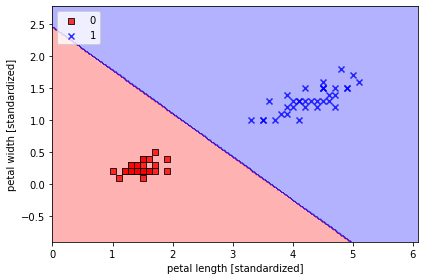

In [6]:
from common import utils 

x_train_01_subset = x_train[(y_train == 0) | (y_train == 1)]
y_train_01_subset = y_train[(y_train == 0) | (y_train == 1)]
lrgd = LogisticRegressionGD(eta=0.05, n_iter=1000, random_state=1)

lrgd.fit(x_train_01_subset, y_train_01_subset)
utils.plot_decision_regions(x_train_01_subset, y_train_01_subset, classifier=lrgd)

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

### 사이킷런을 사용하여 로지스틱 회귀 모델 훈련

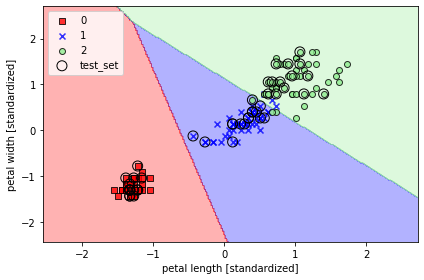

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

sc = StandardScaler()   # 특성 표준화(스케일 조정)을 위해서 StandardScaler 클래스를 사용
sc.fit(x_train)         # fit 함수는 각 특성의 차원마다 평균과 표준편차를 계산한다.
x_train_std = sc.transform(x_train) # transform 함수는 평균과 표준편차를 사용해서 특성을 표준화한다.
x_test_std = sc.transform(x_test)   # 테스트 세트도 같은 비율로 이동(표준화)되도록 같은 평균과 표준편차를 사용한다.

lr = LogisticRegression(solver='liblinear', multi_class='auto', C=100.0, random_state=1)
lr.fit(x_train_std, y_train)

x_combined_std = np.vstack((x_train_std, x_test_std))
y_combined = np.hstack((y_train, y_test))
utils.plot_decision_regions(x_combined_std, y_combined, classifier=lr, test_idx=range(105, 150))

plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [8]:
# 훈련 샘플이 어떤 클래스에 속할 확률은 predict_proba 함수를 사용해서 계산한다.

lr.predict_proba(x_test_std[:3, :])

array([[3.17983737e-08, 1.44886616e-01, 8.55113353e-01],
       [8.33962295e-01, 1.66037705e-01, 4.55557009e-12],
       [8.48762934e-01, 1.51237066e-01, 4.63166788e-13]])

첫번째 행은 첫번째 붓꽃의 클래스 소속 확률, 두번째 행은 두번째 붓꽃의 클래스 소속 확률을 나타낸다.
각 열을 모두 더하면 1이된다.
첫번째 행에서 가장 큰값은 0.853이므로 첫번째 샘플이 클래스 3에 속할 확률이 85.3%이다.
predict 함수를 사용하면 가장 큰 확률을 가진 클래스을 바로 알 수 있다.

In [9]:
lr.predict(x_test_std[:3, :])

# 하나의 샘플의 클래스 레이블을 예측할때는 reshape을 사용해서 입력 데이터를 2차원 베열로 변경한다.
lr.predict(x_test_std[0, :].reshape(1, -1))

array([2])

### Regularization를 사용하여 overfitting 피하기

overfitting은 모델이 훈련 데이터로는 잘 동작하지만 본 적 없는 데이터(테스트 데이터)로는 잘 일반화되지 않는 현상을 말한다.
모델이 overfitting일때, 분산이 크다고 한다. 모델 파라메터가 너무 많아 주어진 데이터에서 너무 복잡한 모델을 만들기 때문이다.
반대로 underfitting은 편향이 크다고 한다. 훈련 데이터에 있는 패턴을 감지할 정도로 충분히 복잡하지 않기 때문이다. 

Regularization는 모델의 복잡도를 조정하는 방법 중 하나이다.
Regularization는 특성 간의 높은 상관관계(collinearity)를 다루거나, 데이터에서 잡음을 제거하여 overfitting을 방지할 수 있는 매우 유용한 방법이다.
Regularization의 개념은 과도한 파라메터(가중치) 값을 제한하기 위해 추가적인 bias를 주입하는 개념이다.

가장 널리 사용되는 Regularization는 L2이다.

다음과 같이 로지스틱 회귀의 비용 함수에 L2 Regularization를 추가하면, 모델 훈련 과정에서 파라메터의 가중치를 줄이는 역할을 한다.

$$J(w) = \sum_{i=1}^n\biggl[ -y^{(i)}\log(\phi(z^{(i)}))-(1-y^{(i)})\log(1-\phi(z^{(i)})) \biggr]+{\lambda \over 2}{\lVert w \lVert}^2$$

$\lambda$ 값을 증가하면 Regularization 강도가 높아진다.
사이킷런의 매개변수 C는 Regularization 하이퍼파라메터 $\lambda$의 역수이다.
따라서 C값을 감소시키면 Regularization 강도가 증가한다. 
두개의 가중치에 대해서 L2 Regularization 효과를 그래프로 나타내면 다음과 같다.
 

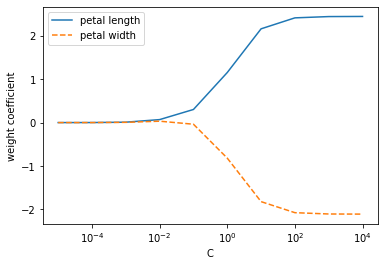

In [12]:
weights, params = [], []
for c in np.arange(-5, 5):  # C값을 바꾸면서 열개의 회귀 모델을 훈련한다.
    lr = LogisticRegression(solver='liblinear', multi_class='auto', C=10.**c, random_state=1)
    lr.fit(x_train_std, y_train)
    # lr.coef_[1]에는 각 속성들의 상관계수 값이 있다.
    # 상관계수는 -1 에서 1까의 값을 가지며 -는 음의 영향력, +는 양의 영향력을 의미한다.
    # 부호와 상관없이 숫자의 절대값은 영향력의 크기를 의미한다.
    weights.append(lr.coef_[1])
    params.append(10.**c)

weights = np.array(weights)
plt.plot(params, weights[:, 0], label='petal length')
plt.plot(params, weights[:, 1], linestyle='--', label='petal width')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='upper left')
plt.xscale('log')
plt.show()

그래프에서 볼 수 있듯이 매개변수 C가 감소하면 가중치 절댓값이 줄어든다. 이것은 Regularization의 강도가 증가한 것을 의미한다.

